In [25]:
import warnings 
warnings.filterwarnings("ignore")

from monai.transforms import (
    Activations,
    AddChannel,
    AsChannelFirst,
    AsDiscrete,
    Compose,
    EnsureType,
    LoadImage,
    RandFlip,
    RandSpatialCrop,
    RandZoom,
    Resize,
    ScaleIntensity,
    ScaleIntensityRange,
    SpatialCrop,
    ToTensor,
)
from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
import monai.utils as utils

import torch

import matplotlib.pyplot as plt

import os
from glob import glob

import numpy as np

import itk

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

In [26]:
img1_dir = "../../Data/VFoldData/ROIData/"

all_images = sorted(glob(os.path.join(img1_dir, '*Class[NS]*.roi.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*Class[NS]*.roi.overlay.nii.gz')))

num_classes = 2

num_slices = 48

num_workers_te = 0
batch_size_te = 1

model_filename_base = "BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold"

num_images = len(all_images)

print(num_images)

num_folds = 15

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
fold_label_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)
        
train_files = []
train_labels = []
val_files = []
val_labels = []
test_files = []
test_labels = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    img = [im for im in all_images if any(pref in im for pref in tr_folds)]
    seg = []
    for im in img:
        if "ClassN" in im:
            seg.append(0)
        else:
            seg.append(1)
    print(seg)
    train_files.append(img)
    train_labels.append(seg)
    img = [im for im in all_images if any(pref in im for pref in va_folds)]
    seg = []
    for im in img:
        if "ClassN" in im:
            seg.append(0)
        else:
            seg.append(1)
    print(seg)
    val_files.append(img)
    val_labels.append(seg)
    img = [im for im in all_images if any(pref in im for pref in te_folds)]
    seg = []
    for im in img:
        if "ClassN" in im:
            seg.append(0)
        else:
            seg.append(1)
    print(seg)
    test_files.append(img)
    test_labels.append(seg)
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))
    print(len(train_labels[i]),len(val_labels[i]),len(test_labels[i]))

108
[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[0, 0, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 0, 0, 0]
94 6 8
94 6 8
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0]
91 8 9
91 8 9
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1,

In [27]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        AsChannelFirst(),
        ARGUS_RandSpatialCropSlices(
            num_slices=num_slices,
            axis=0,
            reduce_to_statistics=True),
        ScaleIntensity(
            channel_wise=True),
        RandFlip(prob=0.5, 
            spatial_axis=1),
        RandZoom(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keep_size=True,
            mode='bilinear'),
        EnsureType(),
    ]
)

val_transforms = Compose(
    [
        LoadImage(image_only=True), 
        AsChannelFirst(),
        ARGUS_RandSpatialCropSlices(
            num_slices=num_slices,
            axis=0,
            center_slice=30,
            reduce_to_statistics=True),
        ScaleIntensity(), 
        EnsureType()
    ]
)

y_pred_trans = Compose([EnsureType(), Activations(softmax=True)])
y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

In [28]:
class PTXDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [29]:
test_ds = [PTXDataset(test_files[i], test_labels[i], val_transforms) for i in range(num_folds)]
test_loader = [torch.utils.data.DataLoader(test_ds[i], batch_size=batch_size_te, shuffle=False, num_workers=num_workers_te) 
                for i in range(num_folds)]

In [30]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:1")

In [104]:
def plot_vfold_training_curves(vfold_num, test_loader, graph):
    if graph:
        print("   VFOLD =", vfold_num, "of", num_folds)
    
    correct = 0
    incorrect = 0
    
    slice_correct = 0
    slice_incorrect = 0
    
    false_negatives = 0
    slice_false_negatives = 0
    
    loss_file = model_filename_base+"_loss_"+str(vfold_num)+".npy"
    if os.path.exists(loss_file):
        epoch_loss_values = np.load(loss_file)
        
        metric_file = model_filename_base+"_auc_"+str(vfold_num)+".npy"
        metric_values = np.load(metric_file)
    
        if graph:
            plt.figure("train", (12, 6))
            plt.subplot(1, 2, 1)
            plt.title("Epoch Average Loss")
            x = [i + 1 for i in range(len(epoch_loss_values))]
            y = epoch_loss_values
            plt.xlabel("epoch")
            plt.plot(x, y)
            #plt.ylim([0.2,0.8])
            plt.subplot(1, 2, 2)
            plt.title("Val Mean Dice")
            x = [2 * (i + 1) for i in range(len(metric_values))]
            y = metric_values
            plt.xlabel("epoch")
            plt.plot(x, y)
            #plt.ylim([0.2,0.8])
            plt.show()
    
    model_file = model_filename_base+'_'+str(vfold_num)+'.pth'
    print(model_file)
    if os.path.exists(model_file):
        model = DenseNet121(spatial_dims=2, in_channels=2,
                            out_channels=num_classes).to(device)
        loss_function = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), 1e-5)
        auc_metric = ROCAUCMetric()
        model.load_state_dict(torch.load(model_file))
        model.eval()
        i = 0
        fname = os.path.basename(test_files[vfold_num][i])
        prevfname = fname
        count1 = 0
        count = 0
        with torch.no_grad():
            for b,test_data in enumerate(test_loader):
                timages, tlabels = (
                    test_data[0].to(device),
                    test_data[1].to(device),
                )
                y_pred = model(timages)
                y = tlabels
                y_onehot = y_trans(decollate_batch(y))
                y_pred_act = y_pred_trans(decollate_batch(y_pred))
                #print("y_pred =", y_pred)
                #print("y =", y)
                #print("y_pred_act =", y_pred_act)
                #print("y_onehot =", y_onehot)

                diff = 0
                for c in range(num_classes):
                    diff += (y_onehot[0][c] - y_pred_act[0][c].cpu())**2
                result = float(diff)
                acc_value = abs(y_pred_act[0].argmax(dim=0) - y)
                
                prevfname = fname
                fname = os.path.basename(test_files[vfold_num][i])
                
                if fname[:22]!=prevfname[:22]:
                    if graph:
                        print(prevfname[:22], "Number of sliding =", count1, "of", count)
                    if count1 == count:
                        if graph:
                            print("  Winner = Sliding")
                        if y == 1:
                            correct += 1
                        else:
                            incorrect += 1
                            false_negatives += 1
                            print("FN Patient =", prevfname)
                    else:
                        if graph:
                            print("  Winner = Not Sliding")
                        if y == 0:
                            correct += 1
                        else:
                            incorrect += 1
                            print("FP Patient =", prevfname)
                    if graph:
                        print()
                        print()
                    count1 = 0
                    count = 0
                    
                if acc_value == 0:
                    if y == 1:
                        count1 += 1
                    slice_correct += 1
                else:
                    slice_incorrect += 1
                    if y == 0:
                        slice_false_negatives += 1
                        print("   FN ROI =", fname)
                count += 1

                if graph:
                    print("  ", fname)

                    plt.figure("check", (18, 6))
                    plt.subplot(1, 3, 1)
                    plt.title(f"image {i}")
                    tmpV = timages[0,0,:,:].cpu()
                    plt.imshow(tmpV, cmap="gray")
                    print("   Diff =", float(diff))
                    print("   Acc value =", int(acc_value))
                    print("   Ideal = ", int(y), "  Predicted = ", int(y_pred_act[0].argmax(dim=0)))
                    plt.show()
                    print()
                    
                i += 1
                    
            if graph:
                print(prevfname[:22], "NUmber of sliding =", count1, "of", count)
            if count1 == count:
                if graph:
                    print("  Winner = Sliding")
                if prevfname[3] == 's':
                    correct += 1
                else:
                    incorrect += 1
                    false_negatives += 1
                    print("FN Patient =", fname)
            else:
                if graph:
                    print("  Winner = Not Sliding")
                if prevfname[3] == 'n':
                    correct += 1
                else:
                    incorrect += 1
                    print("FP Patient =", fname)
            if graph:
                print()
                print()
                
    return correct, incorrect, false_negatives, slice_correct, slice_incorrect, slice_false_negatives

   VFOLD = 0 of 15


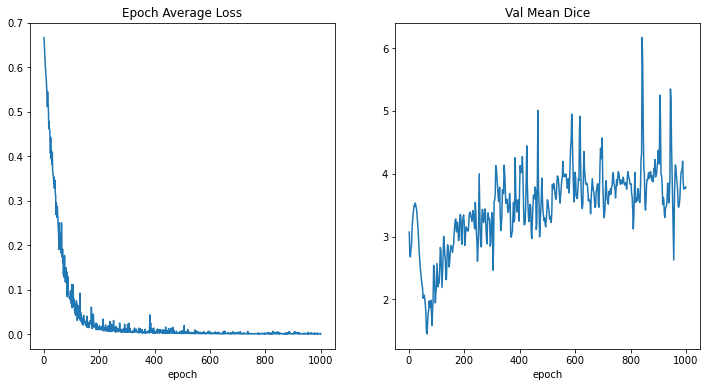

BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold_0.pth
   236s_iimage_1139765223418_CLEAN_ClassS_166-294.roi.nii.gz
   Diff = 0.013819890096783638
   Acc value = 0
   Ideal =  1   Predicted =  1


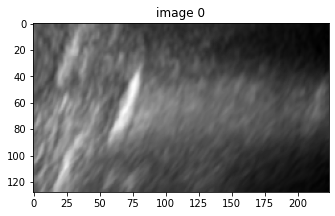


   236s_iimage_1139765223418_CLEAN_ClassS_66-194.roi.nii.gz
   Diff = 1.3555240631103516
   Acc value = 1
   Ideal =  1   Predicted =  0


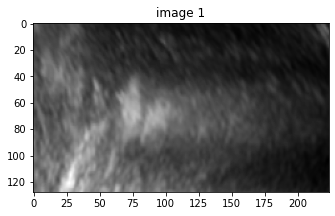


236s_iimage_1139765223 Number of sliding = 1 of 2
  Winner = Not Sliding
FP Patient = 236s_iimage_1139765223418_CLEAN_ClassS_66-194.roi.nii.gz


   236s_iimage_1327616672148_clean_ClassS_158-286.roi.nii.gz
   Diff = 0.06865503638982773
   Acc value = 0
   Ideal =  1   Predicted =  1


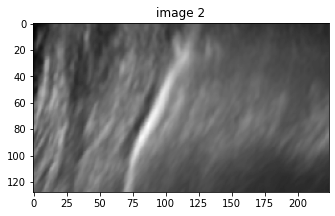


236s_iimage_1327616672 Number of sliding = 1 of 1
  Winner = Sliding


   237s_iimage_24164968068436_CLEAN_ClassS_172-300.roi.nii.gz
   Diff = 1.4846900701522827
   Acc value = 1
   Ideal =  1   Predicted =  0


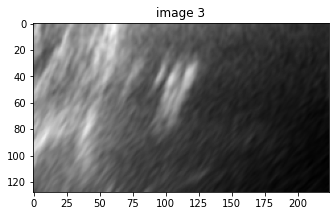


   237s_iimage_24164968068436_CLEAN_ClassS_38-166.roi.nii.gz
   Diff = 1.4801067113876343
   Acc value = 1
   Ideal =  1   Predicted =  0


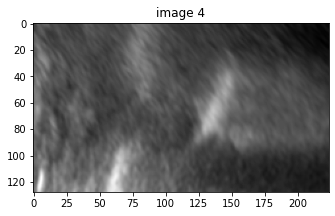


237s_iimage_2416496806 Number of sliding = 0 of 2
  Winner = Not Sliding


   247ns_image_2734882394424_CLEAN_ClassN_83-211.roi.nii.gz
   Diff = 0.12849418818950653
   Acc value = 0
   Ideal =  0   Predicted =  0


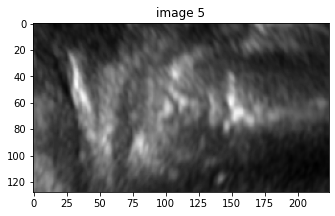


247ns_image_2734882394 Number of sliding = 0 of 1
  Winner = Not Sliding


   FN ROI = 247ns_image_2743083265515_CLEAN_ClassN_126-254.roi.nii.gz
   247ns_image_2743083265515_CLEAN_ClassN_126-254.roi.nii.gz
   Diff = 0.5213258862495422
   Acc value = 1
   Ideal =  0   Predicted =  1


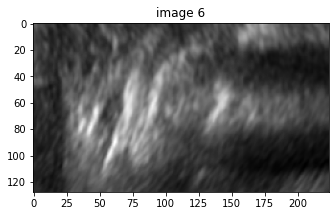


   247ns_image_2743083265515_CLEAN_ClassN_60-188.roi.nii.gz
   Diff = 4.684131999965757e-05
   Acc value = 0
   Ideal =  0   Predicted =  0


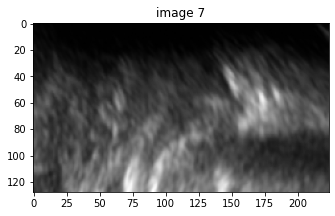


247ns_image_2743083265 NUmber of sliding = 0 of 2
  Winner = Not Sliding


   VFOLD = 1 of 15


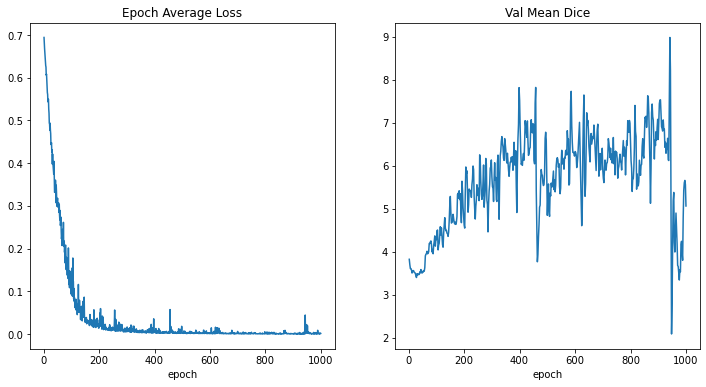

BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold_1.pth
   004s_iimage_73815992352100_clean_ClassS_179-307.roi.nii.gz
   Diff = 1.9979392290115356
   Acc value = 1
   Ideal =  1   Predicted =  0


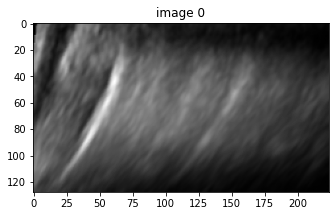


   004s_iimage_73815992352100_clean_ClassS_70-198.roi.nii.gz
   Diff = 1.997638463973999
   Acc value = 1
   Ideal =  1   Predicted =  0


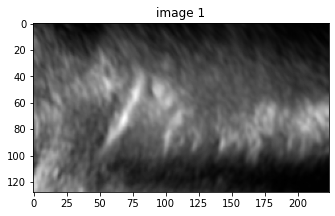


004s_iimage_7381599235 Number of sliding = 0 of 2
  Winner = Not Sliding
FP Patient = 004s_iimage_73815992352100_clean_ClassS_70-198.roi.nii.gz


   004s_iimage_74132233134844_clean_ClassS_192-320.roi.nii.gz
   Diff = 1.8984975814819336
   Acc value = 1
   Ideal =  1   Predicted =  0


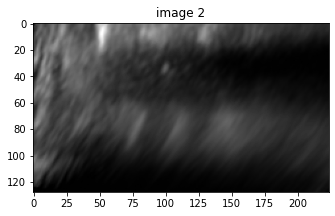


   004s_iimage_74132233134844_clean_ClassS_86-214.roi.nii.gz
   Diff = 1.7681843042373657
   Acc value = 1
   Ideal =  1   Predicted =  0


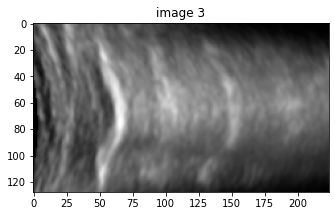


004s_iimage_7413223313 Number of sliding = 0 of 2
  Winner = Not Sliding


   FN ROI = 025ns_Image_262499828648_clean_ClassN_125-253.roi.nii.gz
   025ns_Image_262499828648_clean_ClassN_125-253.roi.nii.gz
   Diff = 1.999998688697815
   Acc value = 1
   Ideal =  0   Predicted =  1


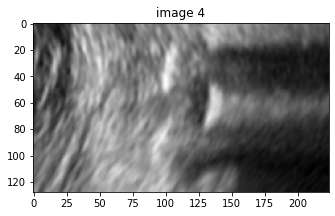


   FN ROI = 025ns_Image_262499828648_clean_ClassN_57-185.roi.nii.gz
   025ns_Image_262499828648_clean_ClassN_57-185.roi.nii.gz
   Diff = 1.915209174156189
   Acc value = 1
   Ideal =  0   Predicted =  1


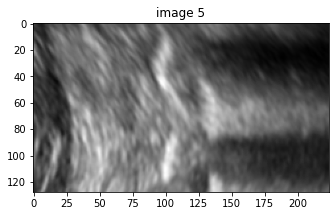


025ns_Image_2624998286 Number of sliding = 0 of 2
  Winner = Not Sliding


   025ns_image_267456908021_clean_ClassN_0-128.roi.nii.gz
   Diff = 2.3643373481263552e-08
   Acc value = 0
   Ideal =  0   Predicted =  0


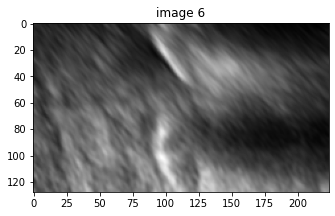


   FN ROI = 025ns_image_267456908021_clean_ClassN_131-259.roi.nii.gz
   025ns_image_267456908021_clean_ClassN_131-259.roi.nii.gz
   Diff = 1.9999791383743286
   Acc value = 1
   Ideal =  0   Predicted =  1


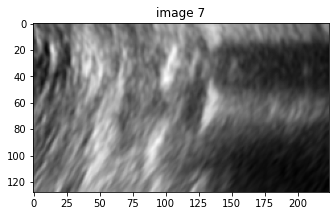


   FN ROI = 025ns_image_267456908021_clean_ClassN_63-191.roi.nii.gz
   025ns_image_267456908021_clean_ClassN_63-191.roi.nii.gz
   Diff = 1.895589828491211
   Acc value = 1
   Ideal =  0   Predicted =  1


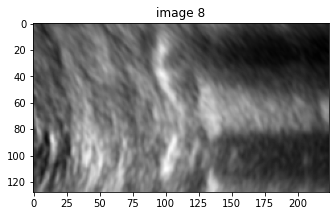


025ns_image_2674569080 NUmber of sliding = 0 of 3
  Winner = Not Sliding


   VFOLD = 2 of 15


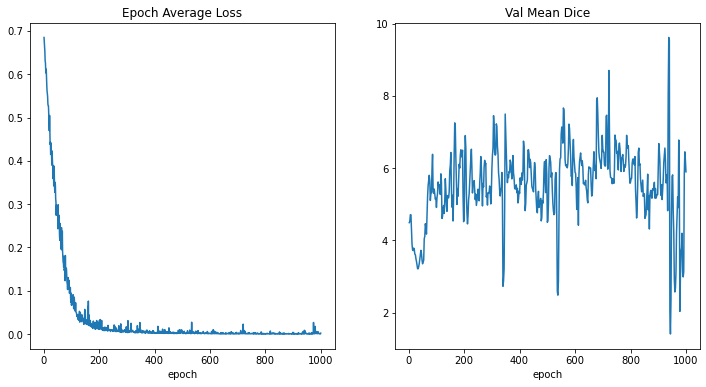

BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold_2.pth
   019s_iimage_10705997566592_CLEAN_ClassS_120-248.roi.nii.gz
   Diff = 1.999237298965454
   Acc value = 1
   Ideal =  1   Predicted =  0


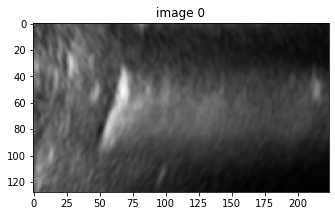


   019s_iimage_10705997566592_CLEAN_ClassS_27-155.roi.nii.gz
   Diff = 1.9994993209838867
   Acc value = 1
   Ideal =  1   Predicted =  0


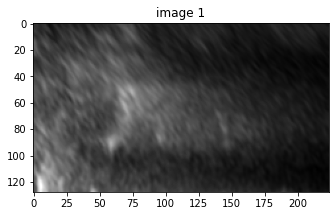


019s_iimage_1070599756 Number of sliding = 0 of 2
  Winner = Not Sliding
FP Patient = 019s_iimage_10705997566592_CLEAN_ClassS_27-155.roi.nii.gz


   019s_iimage_10891015221417_clean_ClassS_151-279.roi.nii.gz
   Diff = 1.5105177164077759
   Acc value = 1
   Ideal =  1   Predicted =  0


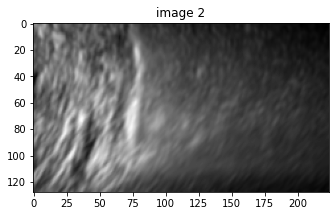


019s_iimage_1089101522 Number of sliding = 0 of 1
  Winner = Not Sliding


   026ns_image_1083297968960_clean_ClassN_148-276.roi.nii.gz
   Diff = 3.783653390598829e-09
   Acc value = 0
   Ideal =  0   Predicted =  0


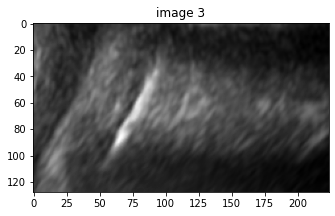


   026ns_image_1083297968960_clean_ClassN_61-189.roi.nii.gz
   Diff = 1.8342364001000533e-06
   Acc value = 0
   Ideal =  0   Predicted =  0


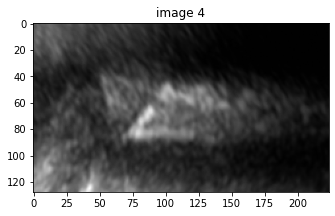


026ns_image_1083297968 Number of sliding = 0 of 2
  Winner = Not Sliding


   026ns_image_1087766719219_clean_ClassN_153-281.roi.nii.gz
   Diff = 2.3264583148829843e-08
   Acc value = 0
   Ideal =  0   Predicted =  0


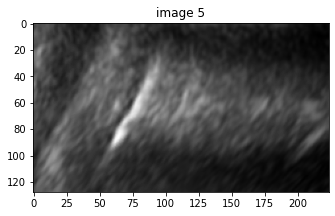


   026ns_image_1087766719219_clean_ClassN_64-192.roi.nii.gz
   Diff = 2.104037776007317e-06
   Acc value = 0
   Ideal =  0   Predicted =  0


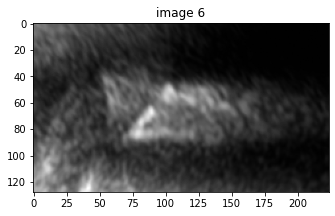


026ns_image_1087766719 NUmber of sliding = 0 of 2
  Winner = Not Sliding


   VFOLD = 3 of 15


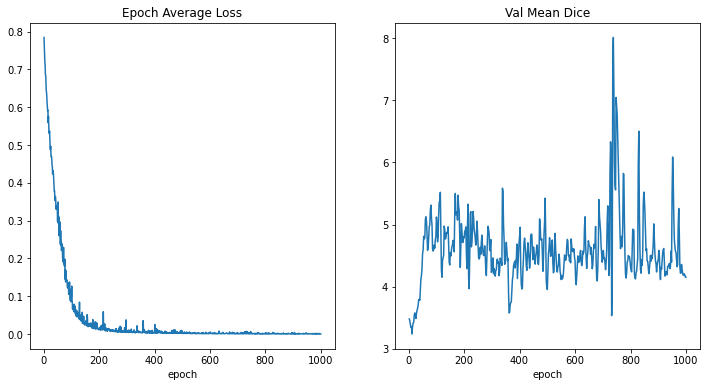

BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold_3.pth
   027ns_image_4641643404894_CLEAN_ClassN_154-282.roi.nii.gz
   Diff = 0.07306094467639923
   Acc value = 0
   Ideal =  0   Predicted =  0


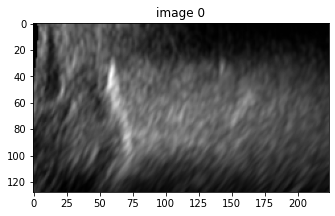


   027ns_image_4641643404894_CLEAN_ClassN_21-149.roi.nii.gz
   Diff = 0.0845244824886322
   Acc value = 0
   Ideal =  0   Predicted =  0


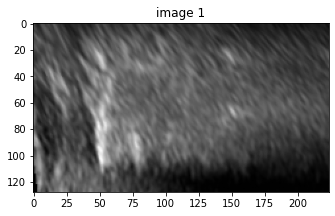


027ns_image_4641643404 Number of sliding = 0 of 2
  Winner = Not Sliding


   027ns_image_4743880599022_clean_ClassN_130-258.roi.nii.gz
   Diff = 3.932202048417821e-07
   Acc value = 0
   Ideal =  0   Predicted =  0


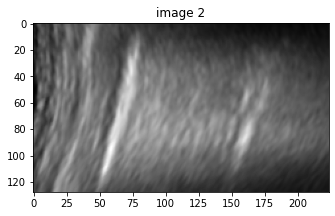


027ns_image_4743880599 Number of sliding = 0 of 1
  Winner = Not Sliding
FP Patient = 027ns_image_4743880599022_clean_ClassN_130-258.roi.nii.gz


   030s_iimage_1180496934444_clean_ClassS_127-255.roi.nii.gz
   Diff = 1.5341562032699585
   Acc value = 1
   Ideal =  1   Predicted =  0


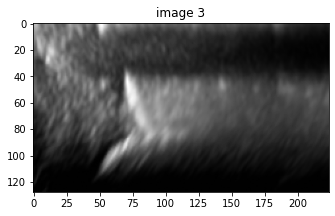


   030s_iimage_1180496934444_clean_ClassS_37-165.roi.nii.gz
   Diff = 1.7669095993041992
   Acc value = 1
   Ideal =  1   Predicted =  0


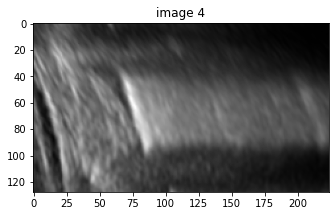


030s_iimage_1180496934 Number of sliding = 0 of 2
  Winner = Not Sliding
FP Patient = 030s_iimage_1180496934444_clean_ClassS_37-165.roi.nii.gz


   030s_iimage_677741729740_clean_ClassS_122-250.roi.nii.gz
   Diff = 0.46491995453834534
   Acc value = 0
   Ideal =  1   Predicted =  1


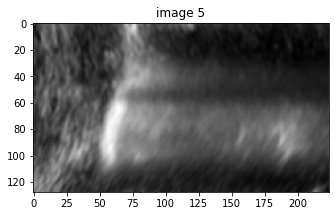


030s_iimage_1180496934 NUmber of sliding = 1 of 1
  Winner = Sliding


   VFOLD = 4 of 15


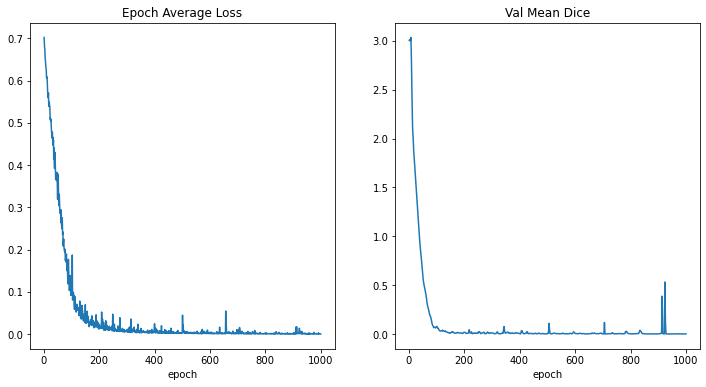

BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold_4.pth
   034s_iimage_3368391807672_clean_ClassS_102-230.roi.nii.gz
   Diff = 1.9969631433486938
   Acc value = 1
   Ideal =  1   Predicted =  0


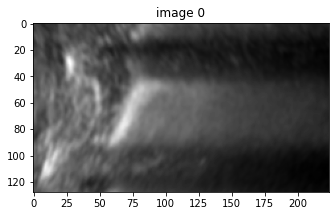


   034s_iimage_3368391807672_clean_ClassS_190-318.roi.nii.gz
   Diff = 0.7123011350631714
   Acc value = 1
   Ideal =  1   Predicted =  0


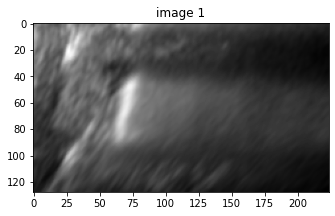


   034s_iimage_3368391807672_clean_ClassS_32-160.roi.nii.gz
   Diff = 1.9999947547912598
   Acc value = 1
   Ideal =  1   Predicted =  0


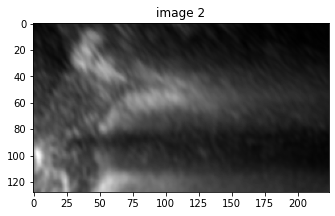


034s_iimage_3368391807 Number of sliding = 0 of 3
  Winner = Not Sliding
FP Patient = 034s_iimage_3368391807672_clean_ClassS_32-160.roi.nii.gz


   034s_iimage_3401832241774_clean_ClassS_132-260.roi.nii.gz
   Diff = 1.9177669286727905
   Acc value = 1
   Ideal =  1   Predicted =  0


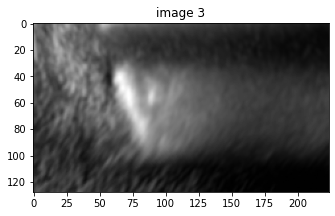


   034s_iimage_3401832241774_clean_ClassS_31-159.roi.nii.gz
   Diff = 1.393681287765503
   Acc value = 1
   Ideal =  1   Predicted =  0


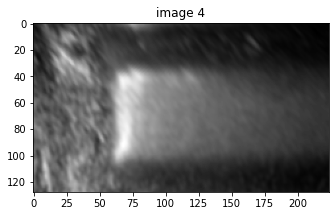


034s_iimage_3401832241 Number of sliding = 0 of 2
  Winner = Not Sliding


   035ns_image_1394469579519_clean_ClassN_11-139.roi.nii.gz
   Diff = 0.0771365687251091
   Acc value = 0
   Ideal =  0   Predicted =  0


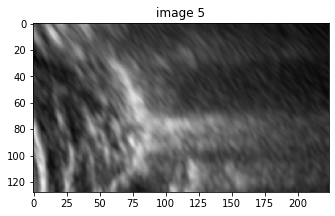


   FN ROI = 035ns_image_1394469579519_clean_ClassN_130-258.roi.nii.gz
   035ns_image_1394469579519_clean_ClassN_130-258.roi.nii.gz
   Diff = 0.9119665026664734
   Acc value = 1
   Ideal =  0   Predicted =  1


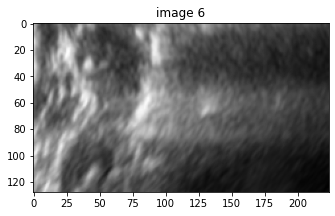


035ns_image_1394469579 Number of sliding = 0 of 2
  Winner = Not Sliding


   035ns_image_1404802450036_clean_ClassN_141-269.roi.nii.gz
   Diff = 0.007464870810508728
   Acc value = 0
   Ideal =  0   Predicted =  0


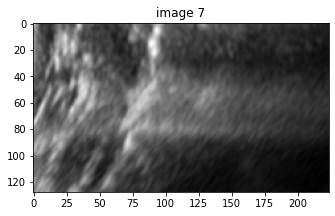


035ns_image_1394469579 NUmber of sliding = 0 of 1
  Winner = Not Sliding


   VFOLD = 5 of 15


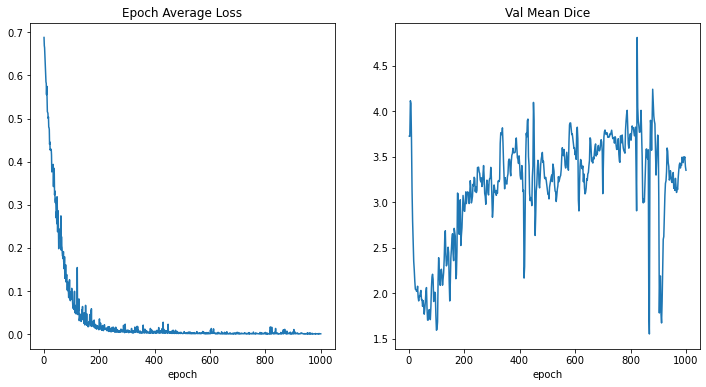

BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold_5.pth
   037s_iimage_588413346180_CLEAN_ClassS_178-306.roi.nii.gz
   Diff = 2.0
   Acc value = 1
   Ideal =  1   Predicted =  0


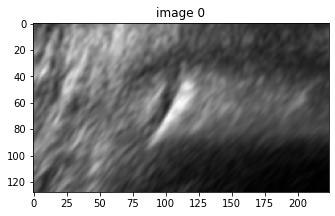


   037s_iimage_588413346180_CLEAN_ClassS_69-197.roi.nii.gz
   Diff = 2.0
   Acc value = 1
   Ideal =  1   Predicted =  0


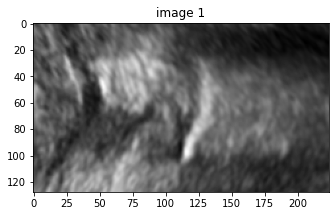


037s_iimage_5884133461 Number of sliding = 0 of 2
  Winner = Not Sliding


   048ns_image_1543571117118_clean_ClassN_188-316.roi.nii.gz
   Diff = 1.0466024192479651e-19
   Acc value = 0
   Ideal =  0   Predicted =  0


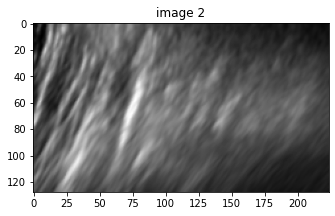


048ns_image_1543571117 Number of sliding = 0 of 1
  Winner = Not Sliding


   048ns_image_1749559540112_clean_ClassN_192-320.roi.nii.gz
   Diff = 5.079640713963829e-22
   Acc value = 0
   Ideal =  0   Predicted =  0


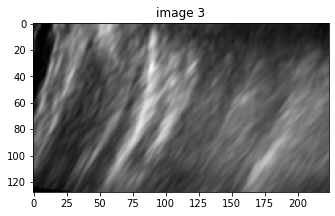


048ns_image_1543571117 NUmber of sliding = 0 of 1
  Winner = Not Sliding


   VFOLD = 6 of 15


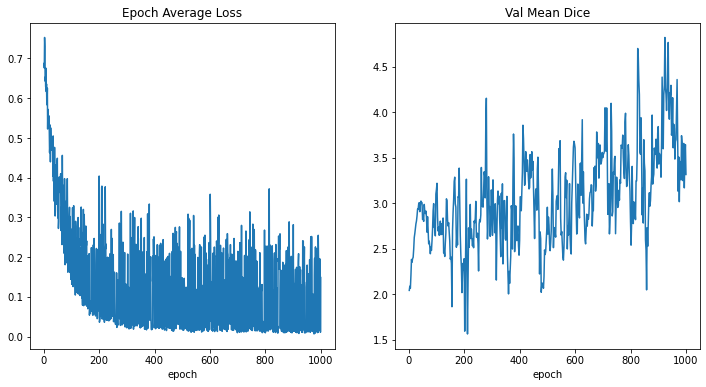

BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold_6.pth
   043s_iimage_10391571128899_CLEAN_ClassS_107-235.roi.nii.gz
   Diff = 1.9956198930740356
   Acc value = 1
   Ideal =  1   Predicted =  0


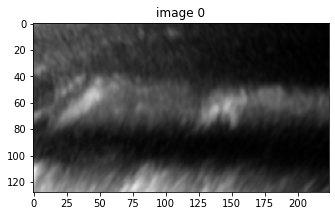


   043s_iimage_10391571128899_CLEAN_ClassS_185-313.roi.nii.gz
   Diff = 1.2937302589416504
   Acc value = 1
   Ideal =  1   Predicted =  0


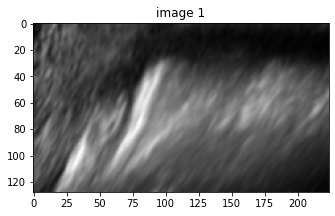


043s_iimage_1039157112 Number of sliding = 0 of 2
  Winner = Not Sliding
FP Patient = 043s_iimage_10391571128899_CLEAN_ClassS_185-313.roi.nii.gz


   043s_iimage_10395655826502_CLEAN_ClassS_102-230.roi.nii.gz
   Diff = 1.9967843294143677
   Acc value = 1
   Ideal =  1   Predicted =  0


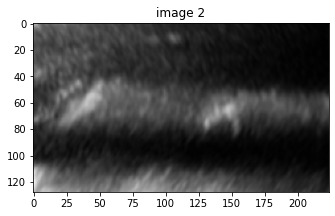


   043s_iimage_10395655826502_CLEAN_ClassS_189-317.roi.nii.gz
   Diff = 1.5355435609817505
   Acc value = 1
   Ideal =  1   Predicted =  0


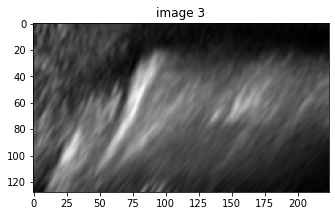


043s_iimage_1039565582 Number of sliding = 0 of 2
  Winner = Not Sliding


   FN ROI = 055ns_image_27180764486244_CLEAN_ClassN_99-227.roi.nii.gz
   055ns_image_27180764486244_CLEAN_ClassN_99-227.roi.nii.gz
   Diff = 1.7957274913787842
   Acc value = 1
   Ideal =  0   Predicted =  1


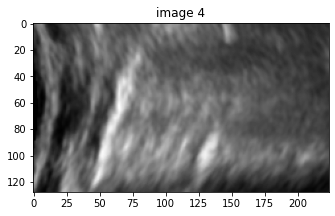


055ns_image_2718076448 Number of sliding = 0 of 1
  Winner = Not Sliding


   FN ROI = 055ns_image_27185428518326_CLEAN_ClassN_101-229.roi.nii.gz
   055ns_image_27185428518326_CLEAN_ClassN_101-229.roi.nii.gz
   Diff = 1.38653564453125
   Acc value = 1
   Ideal =  0   Predicted =  1


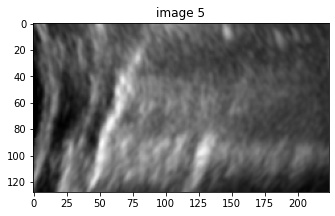


055ns_image_2718076448 NUmber of sliding = 0 of 1
  Winner = Not Sliding


   VFOLD = 7 of 15


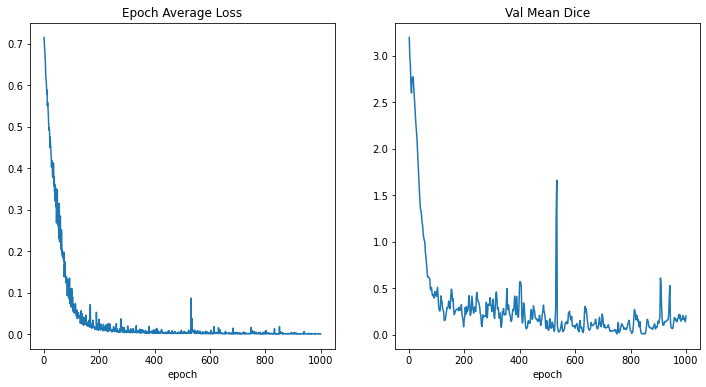

BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold_7.pth
   065s_iimage_1896534330004_clean_ClassS_11-139.roi.nii.gz
   Diff = 2.336431498406455e-05
   Acc value = 0
   Ideal =  1   Predicted =  1


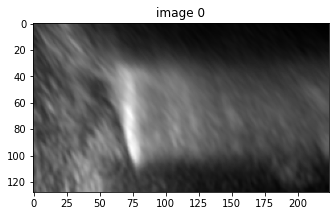


   065s_iimage_1896534330004_clean_ClassS_130-258.roi.nii.gz
   Diff = 1.8103333786712028e-05
   Acc value = 0
   Ideal =  1   Predicted =  1


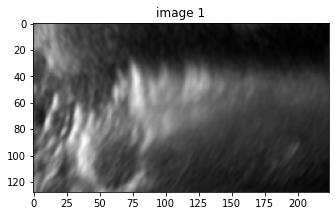


065s_iimage_1896534330 Number of sliding = 2 of 2
  Winner = Sliding


   065s_iimage_1901852337971_clean_ClassS_128-256.roi.nii.gz
   Diff = 0.0025682561099529266
   Acc value = 0
   Ideal =  1   Predicted =  1


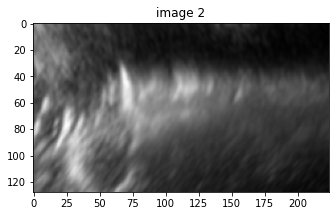


   065s_iimage_1901852337971_clean_ClassS_13-141.roi.nii.gz
   Diff = 1.0924431137482316e-07
   Acc value = 0
   Ideal =  1   Predicted =  1


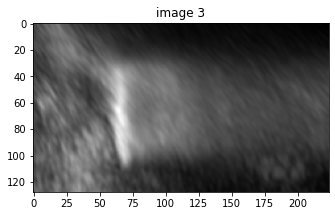


065s_iimage_1901852337 Number of sliding = 2 of 2
  Winner = Sliding
FN Patient = 065s_iimage_1901852337971_clean_ClassS_13-141.roi.nii.gz


   FN ROI = 117ns_image_417221672548_CLEAN_ClassN_40-168.roi.nii.gz
   117ns_image_417221672548_CLEAN_ClassN_40-168.roi.nii.gz
   Diff = 1.9461570978164673
   Acc value = 1
   Ideal =  0   Predicted =  1


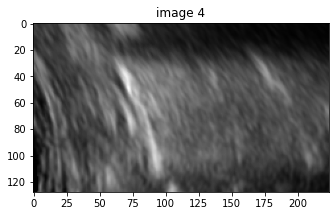


117ns_image_4172216725 Number of sliding = 0 of 1
  Winner = Not Sliding


   FN ROI = 117ns_image_426794579576_CLEAN_ClassN_151-279.roi.nii.gz
   117ns_image_426794579576_CLEAN_ClassN_151-279.roi.nii.gz
   Diff = 1.4124165773391724
   Acc value = 1
   Ideal =  0   Predicted =  1


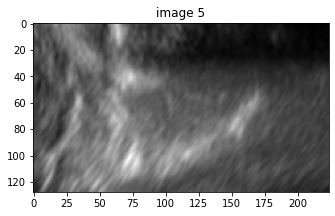


   FN ROI = 117ns_image_426794579576_CLEAN_ClassN_22-150.roi.nii.gz
   117ns_image_426794579576_CLEAN_ClassN_22-150.roi.nii.gz
   Diff = 1.8717474937438965
   Acc value = 1
   Ideal =  0   Predicted =  1


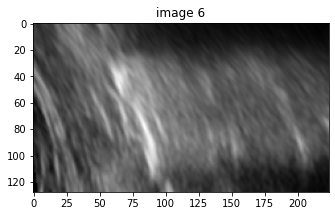


117ns_image_4267945795 NUmber of sliding = 0 of 2
  Winner = Not Sliding


   VFOLD = 8 of 15


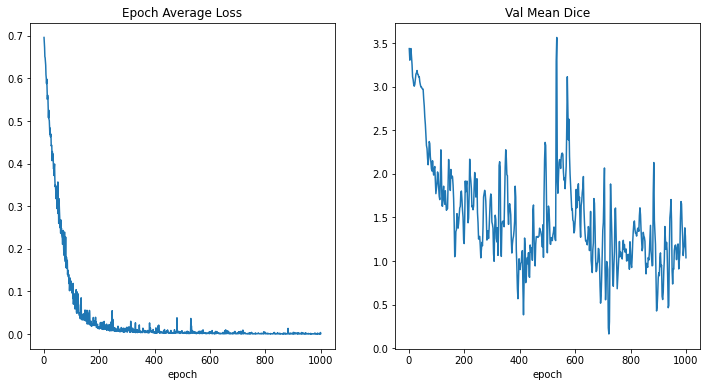

BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold_8.pth
   081s_iimage_2959672151786_clean_ClassS_128-256.roi.nii.gz
   Diff = 1.7854549884796143
   Acc value = 1
   Ideal =  1   Predicted =  0


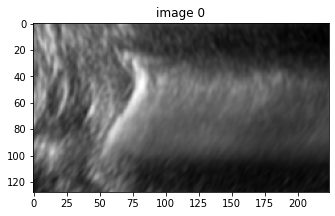


   081s_iimage_2959672151786_clean_ClassS_27-155.roi.nii.gz
   Diff = 1.9639134407043457
   Acc value = 1
   Ideal =  1   Predicted =  0


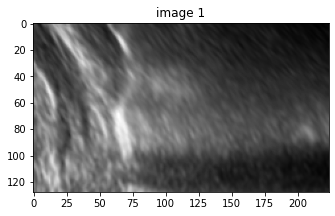


081s_iimage_2959672151 Number of sliding = 0 of 2
  Winner = Not Sliding
FP Patient = 081s_iimage_2959672151786_clean_ClassS_27-155.roi.nii.gz


   081s_iimage_3320344386805_clean_ClassS_94-222.roi.nii.gz
   Diff = 8.017940854188055e-05
   Acc value = 0
   Ideal =  1   Predicted =  1


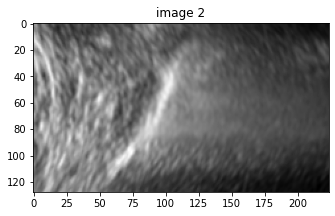


081s_iimage_3320344386 Number of sliding = 1 of 1
  Winner = Sliding
FN Patient = 081s_iimage_3320344386805_clean_ClassS_94-222.roi.nii.gz


   135ns_image_2418161753608_clean_ClassN_75-203.roi.nii.gz
   Diff = 1.3413135491191497e-08
   Acc value = 0
   Ideal =  0   Predicted =  0


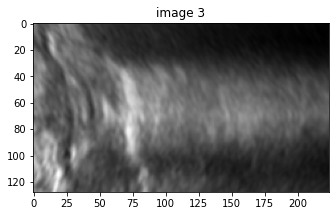


135ns_image_2418161753 Number of sliding = 0 of 1
  Winner = Not Sliding


   135ns_image_2454526567135_CLEAN_ClassN_96-224.roi.nii.gz
   Diff = 0.03505583107471466
   Acc value = 0
   Ideal =  0   Predicted =  0


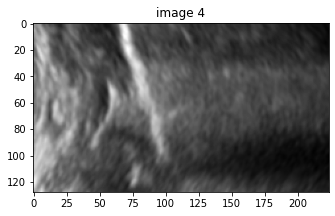


135ns_image_2418161753 NUmber of sliding = 0 of 1
  Winner = Not Sliding


   VFOLD = 9 of 15


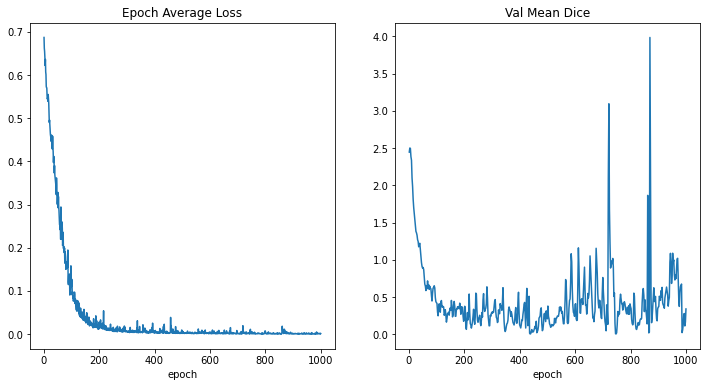

BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold_9.pth
   193ns_image_634125159704_CLEAN_ClassN_145-273.roi.nii.gz
   Diff = 0.0016689072363078594
   Acc value = 0
   Ideal =  0   Predicted =  0


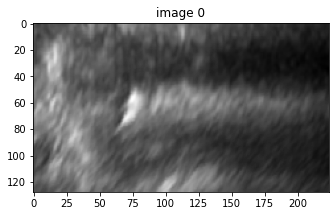


   193ns_image_634125159704_CLEAN_ClassN_192-320.roi.nii.gz
   Diff = 0.00032469298457726836
   Acc value = 0
   Ideal =  0   Predicted =  0


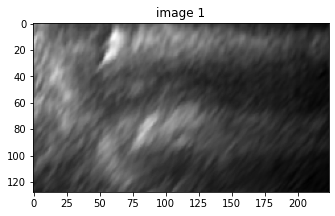


   193ns_image_634125159704_CLEAN_ClassN_36-164.roi.nii.gz
   Diff = 8.21959583729992e-11
   Acc value = 0
   Ideal =  0   Predicted =  0


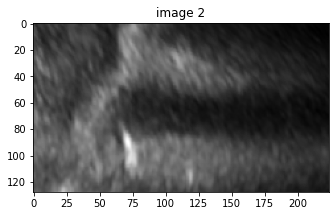


193ns_image_6341251597 Number of sliding = 0 of 3
  Winner = Not Sliding


   193ns_image_642169070951_clean_ClassN_0-128.roi.nii.gz
   Diff = 1.5911502670995503e-10
   Acc value = 0
   Ideal =  0   Predicted =  0


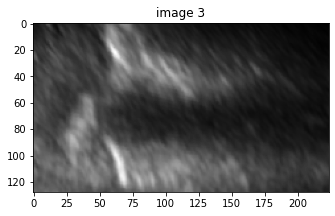


   193ns_image_642169070951_clean_ClassN_119-247.roi.nii.gz
   Diff = 0.012608837336301804
   Acc value = 0
   Ideal =  0   Predicted =  0


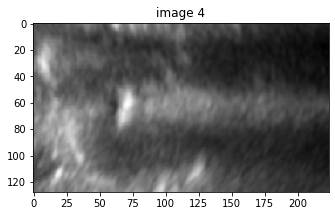


   FN ROI = 193ns_image_642169070951_clean_ClassN_188-316.roi.nii.gz
   193ns_image_642169070951_clean_ClassN_188-316.roi.nii.gz
   Diff = 0.5616194009780884
   Acc value = 1
   Ideal =  0   Predicted =  1


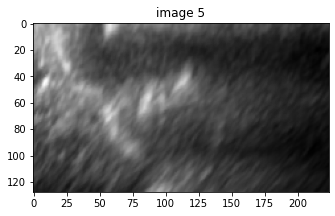


   193ns_image_642169070951_clean_ClassN_42-170.roi.nii.gz
   Diff = 2.106943242097259e-08
   Acc value = 0
   Ideal =  0   Predicted =  0


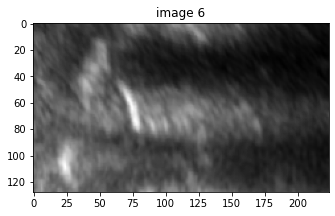


193ns_image_6421690709 Number of sliding = 0 of 4
  Winner = Not Sliding
FP Patient = 193ns_image_642169070951_clean_ClassN_42-170.roi.nii.gz


   206s_iimage_1499268364374_clean_ClassS_10-138.roi.nii.gz
   Diff = 1.986073613166809
   Acc value = 1
   Ideal =  1   Predicted =  0


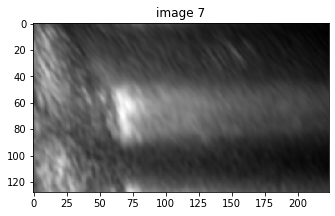


   206s_iimage_1499268364374_clean_ClassS_158-286.roi.nii.gz
   Diff = 1.9935364723205566
   Acc value = 1
   Ideal =  1   Predicted =  0


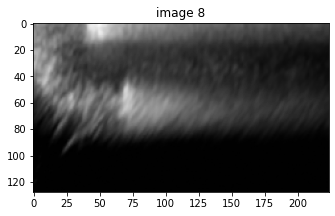


   206s_iimage_1499268364374_clean_ClassS_85-213.roi.nii.gz
   Diff = 1.974573016166687
   Acc value = 1
   Ideal =  1   Predicted =  0


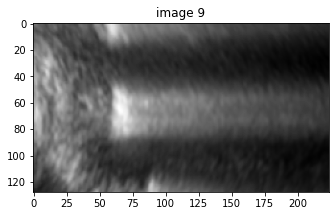


206s_iimage_1499268364 Number of sliding = 0 of 3
  Winner = Not Sliding
FP Patient = 206s_iimage_1499268364374_clean_ClassS_85-213.roi.nii.gz


   206s_iimage_1511338287338_clean_ClassS_0-128.roi.nii.gz
   Diff = 1.8264482021331787
   Acc value = 1
   Ideal =  1   Predicted =  0


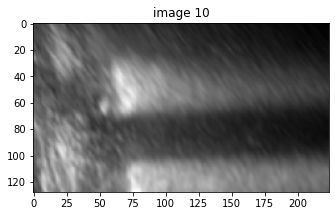


   206s_iimage_1511338287338_clean_ClassS_138-266.roi.nii.gz
   Diff = 1.820747971534729
   Acc value = 1
   Ideal =  1   Predicted =  0


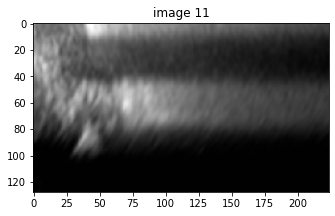


   206s_iimage_1511338287338_clean_ClassS_59-187.roi.nii.gz
   Diff = 1.9855995178222656
   Acc value = 1
   Ideal =  1   Predicted =  0


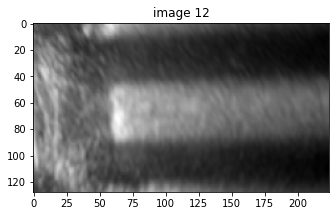


206s_iimage_1511338287 NUmber of sliding = 0 of 3
  Winner = Not Sliding
FP Patient = 206s_iimage_1511338287338_clean_ClassS_59-187.roi.nii.gz


   VFOLD = 10 of 15


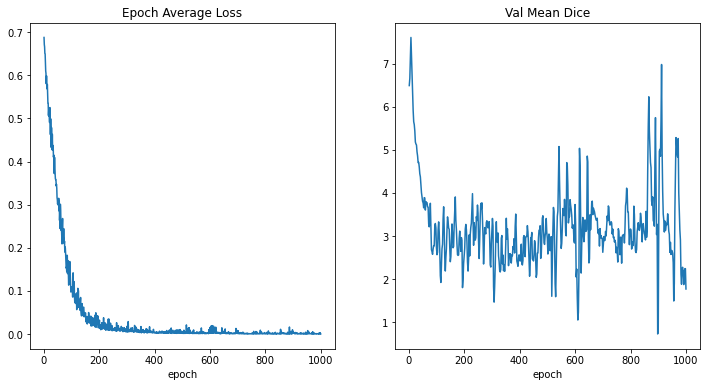

BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold_10.pth
   208s_iimage_104543812690743_CLEAN_ClassS_109-237.roi.nii.gz
   Diff = 1.8867390155792236
   Acc value = 1
   Ideal =  1   Predicted =  0


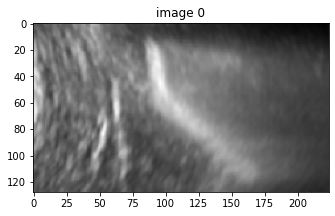


208s_iimage_1045438126 Number of sliding = 0 of 1
  Winner = Not Sliding
FP Patient = 208s_iimage_104543812690743_CLEAN_ClassS_109-237.roi.nii.gz


   208s_iimage_104548309385533_CLEAN_ClassS_110-238.roi.nii.gz
   Diff = 1.769721269607544
   Acc value = 1
   Ideal =  1   Predicted =  0


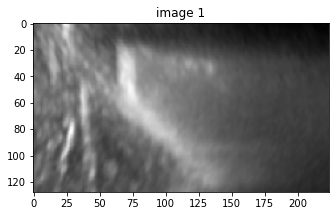


208s_iimage_1045483093 Number of sliding = 0 of 1
  Winner = Not Sliding
FP Patient = 208s_iimage_104548309385533_CLEAN_ClassS_110-238.roi.nii.gz


   208s_iimage_104932526155699_CLEAN_ClassS_93-221.roi.nii.gz
   Diff = 1.9999876022338867
   Acc value = 1
   Ideal =  1   Predicted =  0


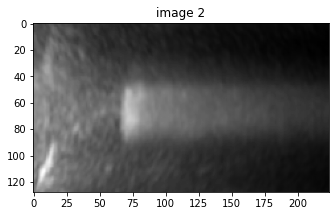


208s_iimage_1049325261 Number of sliding = 0 of 1
  Winner = Not Sliding


   210ns_image_603665940081_clean_ClassN_101-229.roi.nii.gz
   Diff = 1.5611753556576957e-10
   Acc value = 0
   Ideal =  0   Predicted =  0


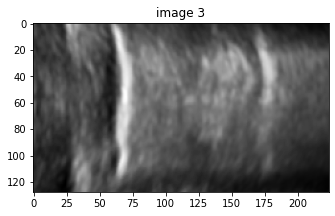


210ns_image_6036659400 Number of sliding = 0 of 1
  Winner = Not Sliding


   210ns_image_614587120545_clean_ClassN_86-214.roi.nii.gz
   Diff = 3.323467581139994e-07
   Acc value = 0
   Ideal =  0   Predicted =  0


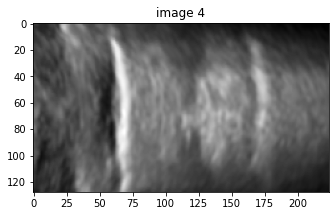


210ns_image_6036659400 NUmber of sliding = 0 of 1
  Winner = Not Sliding


   VFOLD = 11 of 15


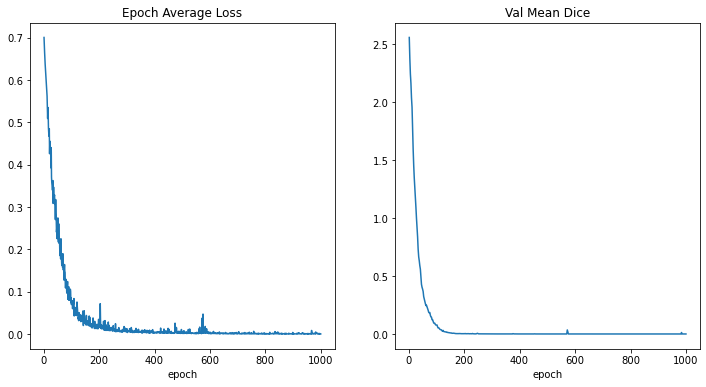

BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold_11.pth
   211s_iimage_3925135436261_clean_ClassS_0-128.roi.nii.gz
   Diff = 0.018756959587335587
   Acc value = 0
   Ideal =  1   Predicted =  1


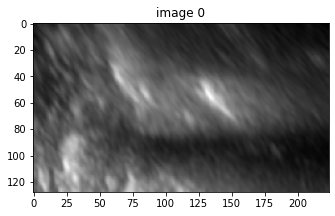


   211s_iimage_3925135436261_clean_ClassS_166-294.roi.nii.gz
   Diff = 1.1373658180236816
   Acc value = 1
   Ideal =  1   Predicted =  0


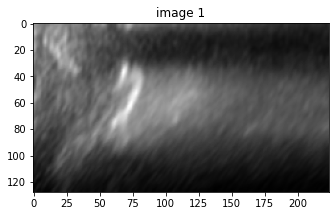


   211s_iimage_3925135436261_clean_ClassS_73-201.roi.nii.gz
   Diff = 2.2345661779277215e-11
   Acc value = 0
   Ideal =  1   Predicted =  1


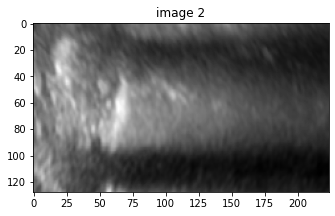


211s_iimage_3925135436 Number of sliding = 2 of 3
  Winner = Not Sliding
FP Patient = 211s_iimage_3925135436261_clean_ClassS_73-201.roi.nii.gz


   211s_iimage_3929217595322_clean_ClassS_163-291.roi.nii.gz
   Diff = 0.16311955451965332
   Acc value = 0
   Ideal =  1   Predicted =  1


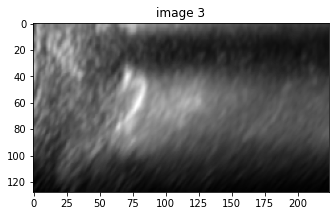


   211s_iimage_3929217595322_clean_ClassS_71-199.roi.nii.gz
   Diff = 3.486746048136924e-12
   Acc value = 0
   Ideal =  1   Predicted =  1


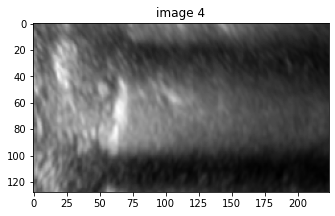


211s_iimage_3929217595 Number of sliding = 2 of 2
  Winner = Sliding
FN Patient = 211s_iimage_3929217595322_clean_ClassS_71-199.roi.nii.gz


   FN ROI = 215ns_image_573611404207_CLEAN_ClassN_121-249.roi.nii.gz
   215ns_image_573611404207_CLEAN_ClassN_121-249.roi.nii.gz
   Diff = 2.0
   Acc value = 1
   Ideal =  0   Predicted =  1


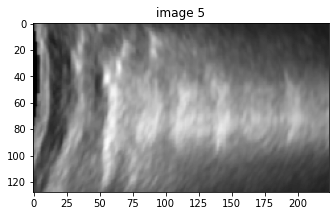


215ns_image_5736114042 Number of sliding = 0 of 1
  Winner = Not Sliding


   FN ROI = 215ns_image_610066411380_CLEAN_ClassN_93-221.roi.nii.gz
   215ns_image_610066411380_CLEAN_ClassN_93-221.roi.nii.gz
   Diff = 1.9993163347244263
   Acc value = 1
   Ideal =  0   Predicted =  1


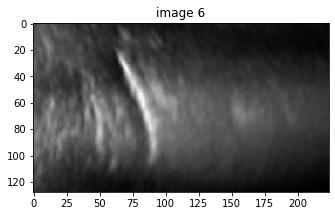


215ns_image_5736114042 NUmber of sliding = 0 of 1
  Winner = Not Sliding


   VFOLD = 12 of 15


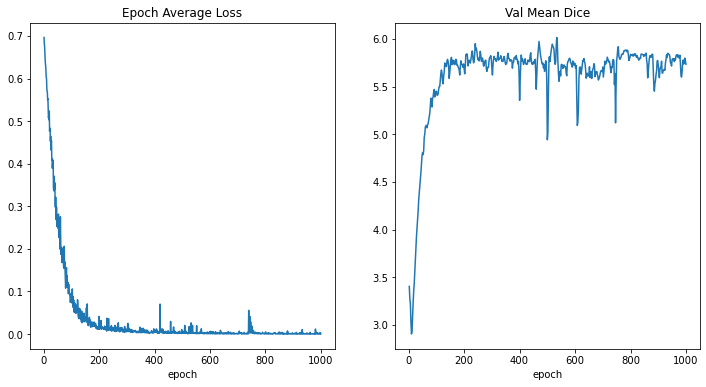

BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold_12.pth
   212s_iimage_128683942015128_CLEAN_ClassS_157-285.roi.nii.gz
   Diff = 1.0048486842606508e-07
   Acc value = 0
   Ideal =  1   Predicted =  1


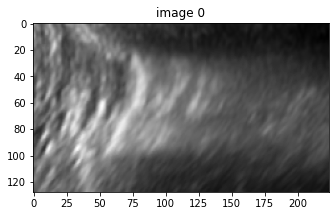


   212s_iimage_128683942015128_CLEAN_ClassS_32-160.roi.nii.gz
   Diff = 0.024584535509347916
   Acc value = 0
   Ideal =  1   Predicted =  1


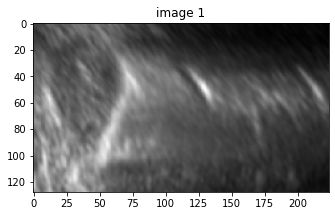


212s_iimage_1286839420 Number of sliding = 2 of 2
  Winner = Sliding


   212s_iimage_128688523296793_CLEAN_ClassS_155-283.roi.nii.gz
   Diff = 5.6323500530197634e-08
   Acc value = 0
   Ideal =  1   Predicted =  1


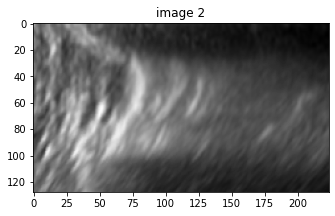


   212s_iimage_128688523296793_CLEAN_ClassS_31-159.roi.nii.gz
   Diff = 0.0005908405291847885
   Acc value = 0
   Ideal =  1   Predicted =  1


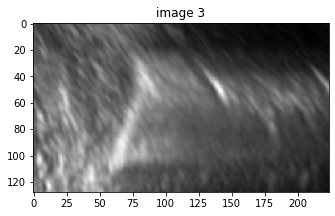


212s_iimage_1286885232 Number of sliding = 2 of 2
  Winner = Sliding


   212s_iimage_128692595484031_CLEAN_ClassS_155-283.roi.nii.gz
   Diff = 2.0229204977795234e-09
   Acc value = 0
   Ideal =  1   Predicted =  1


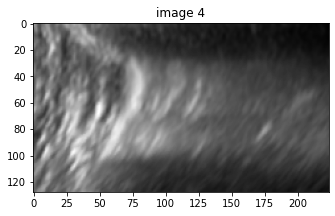


   212s_iimage_128692595484031_CLEAN_ClassS_32-160.roi.nii.gz
   Diff = 0.00011225663183722645
   Acc value = 0
   Ideal =  1   Predicted =  1


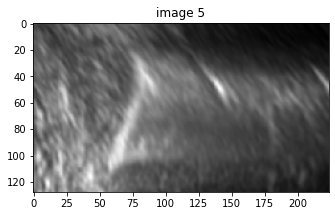


212s_iimage_1286925954 Number of sliding = 2 of 2
  Winner = Sliding
FN Patient = 212s_iimage_128692595484031_CLEAN_ClassS_32-160.roi.nii.gz


   FN ROI = 218ns_image_6056976176281_CLEAN_ClassN_90-218.roi.nii.gz
   218ns_image_6056976176281_CLEAN_ClassN_90-218.roi.nii.gz
   Diff = 1.9802796840667725
   Acc value = 1
   Ideal =  0   Predicted =  1


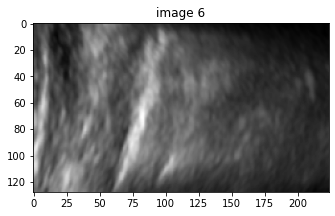


218ns_image_6056976176 Number of sliding = 0 of 1
  Winner = Not Sliding


   FN ROI = 218ns_image_6370410622099_CLEAN_ClassN_135-263.roi.nii.gz
   218ns_image_6370410622099_CLEAN_ClassN_135-263.roi.nii.gz
   Diff = 1.9489237070083618
   Acc value = 1
   Ideal =  0   Predicted =  1


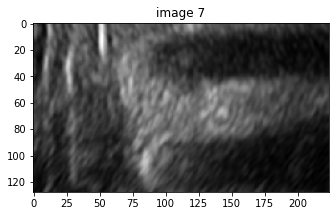


   FN ROI = 218ns_image_6370410622099_CLEAN_ClassN_52-180.roi.nii.gz
   218ns_image_6370410622099_CLEAN_ClassN_52-180.roi.nii.gz
   Diff = 1.9253891706466675
   Acc value = 1
   Ideal =  0   Predicted =  1


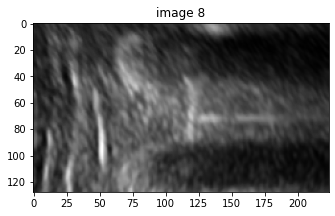


218ns_image_6370410622 NUmber of sliding = 0 of 2
  Winner = Not Sliding


   VFOLD = 13 of 15


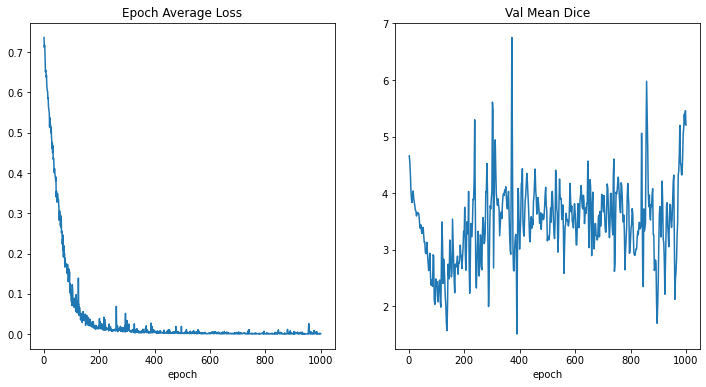

BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold_13.pth
   FN ROI = 219ns_image_1884162273498_clean_ClassN_0-128.roi.nii.gz
   219ns_image_1884162273498_clean_ClassN_0-128.roi.nii.gz
   Diff = 1.9902544021606445
   Acc value = 1
   Ideal =  0   Predicted =  1


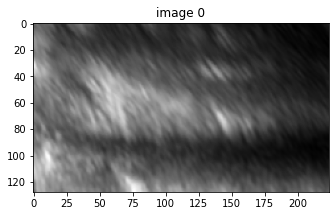


   FN ROI = 219ns_image_1884162273498_clean_ClassN_138-266.roi.nii.gz
   219ns_image_1884162273498_clean_ClassN_138-266.roi.nii.gz
   Diff = 1.9968997240066528
   Acc value = 1
   Ideal =  0   Predicted =  1


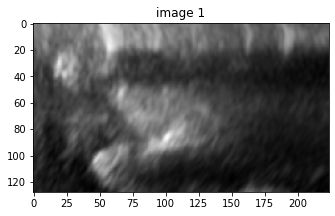


   FN ROI = 219ns_image_1884162273498_clean_ClassN_67-195.roi.nii.gz
   219ns_image_1884162273498_clean_ClassN_67-195.roi.nii.gz
   Diff = 1.9928501844406128
   Acc value = 1
   Ideal =  0   Predicted =  1


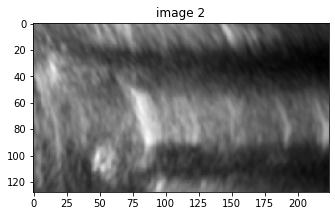


219ns_image_1884162273 Number of sliding = 0 of 3
  Winner = Not Sliding


   FN ROI = 219ns_image_1895283541879_clean_ClassN_0-128.roi.nii.gz
   219ns_image_1895283541879_clean_ClassN_0-128.roi.nii.gz
   Diff = 1.9996439218521118
   Acc value = 1
   Ideal =  0   Predicted =  1


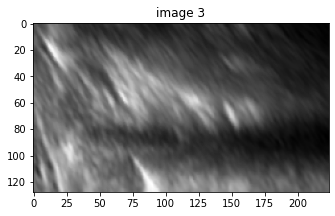


   FN ROI = 219ns_image_1895283541879_clean_ClassN_133-261.roi.nii.gz
   219ns_image_1895283541879_clean_ClassN_133-261.roi.nii.gz
   Diff = 1.999519944190979
   Acc value = 1
   Ideal =  0   Predicted =  1


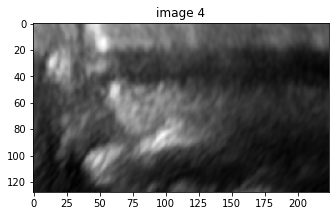


   FN ROI = 219ns_image_1895283541879_clean_ClassN_62-190.roi.nii.gz
   219ns_image_1895283541879_clean_ClassN_62-190.roi.nii.gz
   Diff = 1.9976322650909424
   Acc value = 1
   Ideal =  0   Predicted =  1


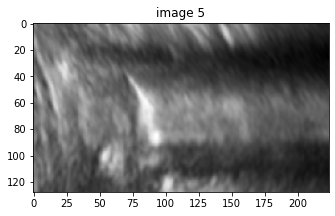


219ns_image_1895283541 Number of sliding = 0 of 3
  Winner = Not Sliding
FP Patient = 219ns_image_1895283541879_clean_ClassN_62-190.roi.nii.gz


   224s_iimage_3308406916756_clean_ClassS_128-256.roi.nii.gz
   Diff = 2.626507580316684e-07
   Acc value = 0
   Ideal =  1   Predicted =  1


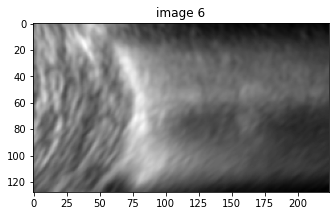


224s_iimage_3308406916 Number of sliding = 1 of 1
  Winner = Sliding


   224s_iimage_3315947589826_clean_ClassS_117-245.roi.nii.gz
   Diff = 1.3152074984645878e-09
   Acc value = 0
   Ideal =  1   Predicted =  1


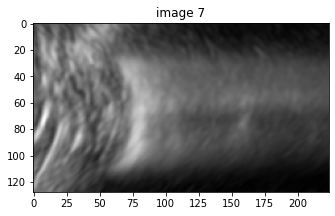


224s_iimage_3308406916 NUmber of sliding = 1 of 1
  Winner = Sliding


   VFOLD = 14 of 15


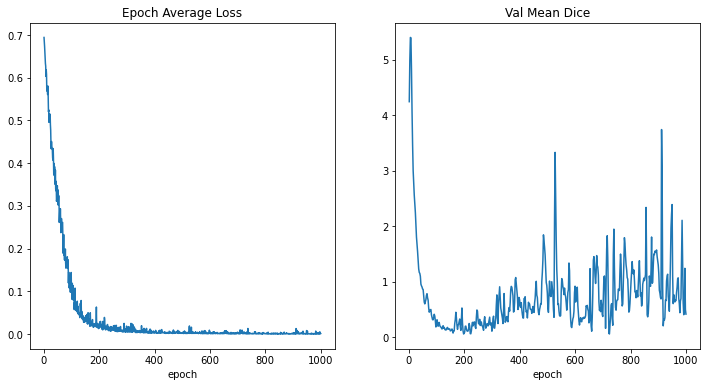

BAMC_PTX_2DROI_DenseNet-2Class.best_model.vfold_14.pth
   FN ROI = 221ns_image_584357289931_clean_ClassN_110-238.roi.nii.gz
   221ns_image_584357289931_clean_ClassN_110-238.roi.nii.gz
   Diff = 1.9302406311035156
   Acc value = 1
   Ideal =  0   Predicted =  1


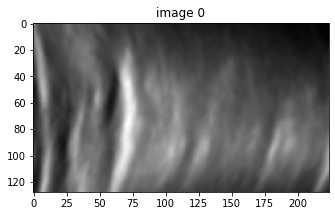


221ns_image_5843572899 Number of sliding = 0 of 1
  Winner = Not Sliding


   FN ROI = 221ns_image_588695055398_clean_ClassN_121-249.roi.nii.gz
   221ns_image_588695055398_clean_ClassN_121-249.roi.nii.gz
   Diff = 1.9586247205734253
   Acc value = 1
   Ideal =  0   Predicted =  1


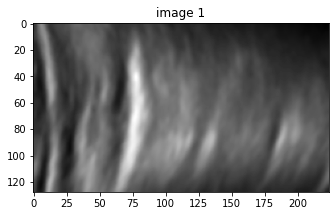


221ns_image_5886950553 Number of sliding = 0 of 1
  Winner = Not Sliding
FP Patient = 221ns_image_588695055398_clean_ClassN_121-249.roi.nii.gz


   228s_iimage_3321463845606_clean_ClassS_192-320.roi.nii.gz
   Diff = 0.0003987897653132677
   Acc value = 0
   Ideal =  1   Predicted =  1


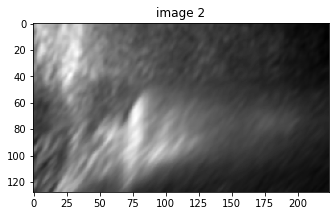


   228s_iimage_3321463845606_clean_ClassS_32-160.roi.nii.gz
   Diff = 0.008312313817441463
   Acc value = 0
   Ideal =  1   Predicted =  1


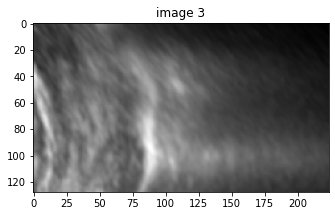


228s_iimage_3321463845 Number of sliding = 2 of 2
  Winner = Sliding


   228s_iimage_3384882513134_clean_ClassS_133-261.roi.nii.gz
   Diff = 0.07811295986175537
   Acc value = 0
   Ideal =  1   Predicted =  1


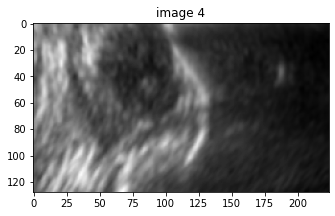


   228s_iimage_3384882513134_clean_ClassS_48-176.roi.nii.gz
   Diff = 0.15198710560798645
   Acc value = 0
   Ideal =  1   Predicted =  1


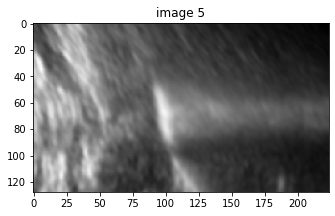


228s_iimage_3384882513 NUmber of sliding = 2 of 2
  Winner = Sliding


   Patients: Correct = 42 Incorrect = 20 Not Sliding as Sliding = 4
     Slices: Correct = 48 Incorrect =  60 Not Sliding as Sliding = 25


In [105]:
correct = 0
incorrect = 0
false_negatives = 0
slice_correct = 0
slice_incorrect = 0
slice_false_negatives = 0
for i in range(num_folds):
    (fcorrect, fincorrect, ffalse_negatives, fslice_correct,
     fslice_incorrect, fslice_false_negatives) = plot_vfold_training_curves(i, test_loader[i], True)
    correct += fcorrect
    incorrect += fincorrect
    false_negatives += ffalse_negatives
    slice_correct += fslice_correct
    slice_incorrect += fslice_incorrect
    slice_false_negatives += fslice_false_negatives
print("   Patients: Correct =", correct, "Incorrect =", incorrect, "Not Sliding as Sliding =", false_negatives)
print("     Slices: Correct =", slice_correct, "Incorrect = ", slice_incorrect, "Not Sliding as Sliding =", slice_false_negatives)